In [ ]:
# Комар Софія | завдання 2 - побудова базової моделі нейронної мережі

In [ ]:
!file /content/archive.zip

/content/archive.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [ ]:
!rm -rf /content/__MACOSX
!jar xvf /content/archive.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 inflated: seg_train/seg_train/mountain/7506.jpg
 inflated: seg_train/seg_train/mountain/7537.jpg
 inflated: seg_train/seg_train/mountain/7539.jpg
 inflated: seg_train/seg_train/mountain/7551.jpg
 inflated: seg_train/seg_train/mountain/7560.jpg
 inflated: seg_train/seg_train/mountain/7565.jpg
 inflated: seg_train/seg_train/mountain/7578.jpg
 inflated: seg_train/seg_train/mountain/7581.jpg
 inflated: seg_train/seg_train/mountain/7586.jpg
 inflated: seg_train/seg_train/mountain/7647.jpg
 inflated: seg_train/seg_train/mountain/7652.jpg
 inflated: seg_train/seg_train/mountain/7654.jpg
 inflated: seg_train/seg_train/mountain/7662.jpg
 inflated: seg_train/seg_train/mountain/767.jpg
 inflated: seg_train/seg_train/mountain/7672.jpg
 inflated: seg_train/seg_train/mountain/7679.jpg
 inflated: seg_train/seg_train/mountain/7681.jpg
 inflated: seg_train/seg_train/mountain/7693.jpg
 inflated: seg_train/seg_train/mountain/7695.jpg
 i

In [ ]:
import os
print(os.listdir("/content"))

['.config', 'drive', 'seg_train', 'archive.zip', 'seg_test', '.ipynb_checkpoints', 'seg_pred', 'sample_data']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) реалізація простої архітектури CNN

class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()

        # перший згортковий шар + Max Pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # другий згортковий шар + Max Pooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # третій згортковий шар + Max Pooling
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # повнозв'язані шари
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)  # вихідний

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 150 → 75
        x = self.pool(F.relu(self.conv2(x)))  # 75 → 37
        x = self.pool(F.relu(self.conv3(x)))  # 37 → 18

        x = torch.flatten(x, 1)  # у вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Softmax

        return x

model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
x = torch.randn(1, 3, 150, 150).to(device)
output = model(x)
print(output.shape)  #  [1, 6]

torch.Size([1, 6])


In [ ]:
# висновок до 1-го пункту
# маємо 3 згорткові шари (conv1, conv2, conv3)
# кількість фільтрів: 32 → 64 → 128
# розмір ядра: 3x3
# padding=1, щоб зберегти розмір зображення
# активація ReLU (F.relu())

# MaxPooling(2x2) після кожного згорткового шару
# conv1 → розмір зменшився (150 → 75)
# conv2 → розмір (75 → 37)
# conv3 → розмір (37 → 18)

# fc1: 128 * 18 * 18 → 256
# fc2: 256 → 128
# fc3: 128 → 6 (вихідний шар)

# активація ReLU у прихованих шарах
# вихідний шар fc3 з Softmax (у функції втрат)

In [ ]:
import torch.optim as optim

# 2) Налаштування функції втрат і оптимізатора

criterion = nn.CrossEntropyLoss()  # categorical crossentropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # learning Rate Scheduler
print(model)

# висновок до 2-го пункту
# після першого тренування моделі зменшила lr до 0.0001 - призвело до покращення результатів
# у мене вийшло отримати наступні результати: Train Acc ≈ 91%, Val Acc ≈ 83%

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import os
import shutil

In [ ]:
# 3) Тренування моделі на невеликій кількості епох

def remove_checkpoints(path):
    checkpoint_path = os.path.join(path, '.ipynb_checkpoints')
    if os.path.isdir(checkpoint_path):
        shutil.rmtree(checkpoint_path)
        print(f"removed: {checkpoint_path}")

data_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"

remove_checkpoints(data_dir)
remove_checkpoints(test_dir)

def is_valid_file(path):
    return ".ipynb_checkpoints" not in path.lower()

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"{self.imgs[index]}")
            return self.__getitem__((index + 1) % len(self.imgs))

train_dataset = CustomImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
# train_dataset = datasets.ImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform, is_valid_file=is_valid_file)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"К-сть train-зразків -> {len(train_data)}")
print(f"К-сть validation-зразків -> {len(val_data)}")
print(f"К-сть test-зразків -> {len(test_dataset)}")

for images, labels in train_loader:
    print(f"Батч розміру {images.size()}, мітки: {labels}")
    break

К-сть train-зразків -> 11227
К-сть validation-зразків -> 2807
К-сть test-зразків -> 3000
Батч розміру torch.Size([32, 3, 150, 150]), мітки: tensor([4, 5, 5, 1, 3, 3, 0, 0, 2, 3, 0, 0, 5, 2, 5, 2, 5, 0, 0, 1, 1, 1, 3, 1,
        2, 2, 1, 1, 1, 0, 4, 5])


In [ ]:
import torch
# GPU
print("CUDA:", torch.cuda.is_available())

CUDA: True


In [ ]:
print(torch.cuda.is_available())  # True - GPU доступний
print(torch.cuda.get_device_name(0))  # назва GPU

True
Tesla T4


In [ ]:
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(correct / total)

    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, F1-score: {f1:.4f}")

Epoch 1/20, Train Loss: 1.2149, Train Acc: 0.5244, Val Loss: 0.9802, Val Acc: 0.6199, F1-score: 0.6248
Epoch 2/20, Train Loss: 0.9635, Train Acc: 0.6308, Val Loss: 0.8923, Val Acc: 0.6591, F1-score: 0.6635
Epoch 3/20, Train Loss: 0.8578, Train Acc: 0.6821, Val Loss: 0.7654, Val Acc: 0.7189, F1-score: 0.7203
Epoch 4/20, Train Loss: 0.7726, Train Acc: 0.7152, Val Loss: 0.7455, Val Acc: 0.7260, F1-score: 0.7296
Epoch 5/20, Train Loss: 0.6961, Train Acc: 0.7464, Val Loss: 0.6534, Val Acc: 0.7602, F1-score: 0.7602
Epoch 6/20, Train Loss: 0.6430, Train Acc: 0.7701, Val Loss: 0.5958, Val Acc: 0.7870, F1-score: 0.7876
Epoch 7/20, Train Loss: 0.5963, Train Acc: 0.7867, Val Loss: 0.5688, Val Acc: 0.7905, F1-score: 0.7936
Epoch 8/20, Train Loss: 0.5650, Train Acc: 0.7955, Val Loss: 0.5996, Val Acc: 0.7905, F1-score: 0.7912
Epoch 9/20, Train Loss: 0.5357, Train Acc: 0.8056, Val Loss: 0.5647, Val Acc: 0.7980, F1-score: 0.7977
Epoch 10/20, Train Loss: 0.5022, Train Acc: 0.8221, Val Loss: 0.5410, Val

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/cnn_trained_model.pth")

In [ ]:
!mv /content/seg_train /content/drive/MyDrive/seg_train
!mv /content/seg_test /content/drive/MyDrive/seg_test
!mv /content/seg_pred /content/drive/MyDrive/seg_pred

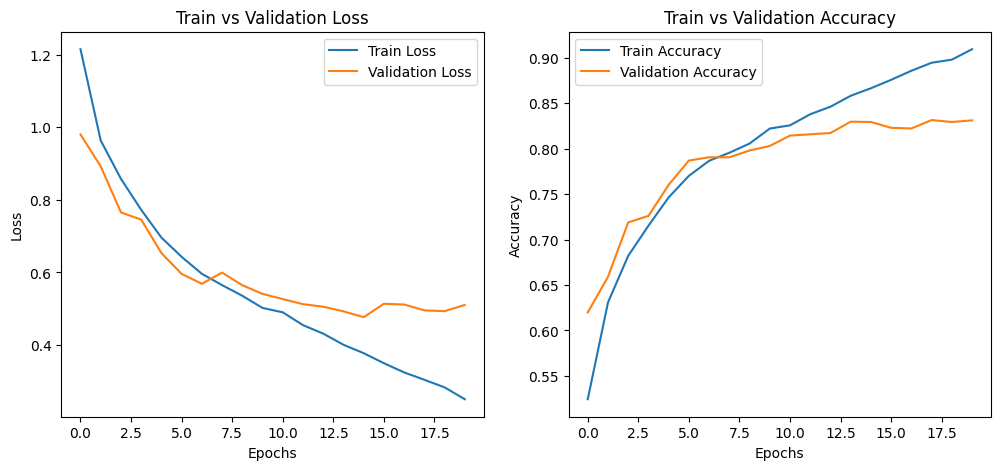

In [ ]:
# Візуалізація результатів
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# висновок до 3-го пункту
# Train Loss зменшується стабільно → модель навчається
# Validation Loss теж зменшується → модель не переобучається, що вже є добре
# для покращення результатів можна ще використати аугментацію